## Weight balancing used to balance classes in train, valid, and test sets. Cross entropy used for loss function. AdaBound used for optimizer: https://github.com/Luolc/AdaBound

### Loading skin lesion test set files and creating train/test functions

In [23]:
import numpy as np
import matplotlib.pyplot as plt 
from glob import glob

# load filenames for human and dog images
melanoma_test_files = np.array(glob(r"D:\Python\Dermatology AI\data\test\melanoma\*"))
nevus_test_files = np.array(glob(r"D:\Python\Dermatology AI\data\test\nevus\*"))
seborrheic_keratosis_test_files = np.array(glob(r"D:\Python\Dermatology AI\data\test\seborrheic_keratosis\*"))

# print number of images in each dataset
print('There are %d total melanoma test set images.' % len(melanoma_test_files))
print('There are %d total nevus test set images.' % len(nevus_test_files))
print('There are %d total seborrheic keratosis test set images.' % len(seborrheic_keratosis_test_files))

There are 117 total melanoma test set images.
There are 393 total nevus test set images.
There are 90 total seborrheic keratosis test set images.


### Example melanoma image

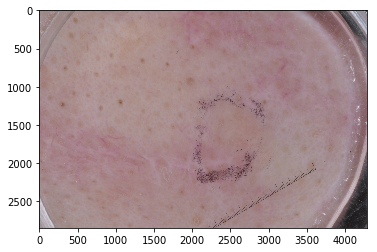

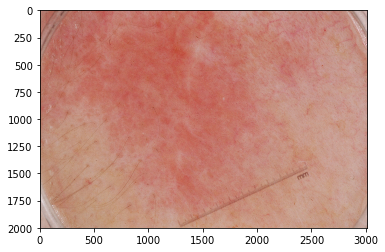

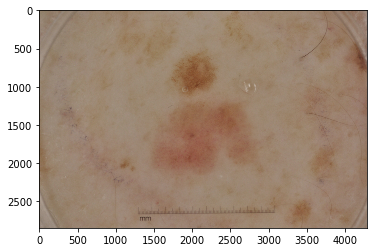

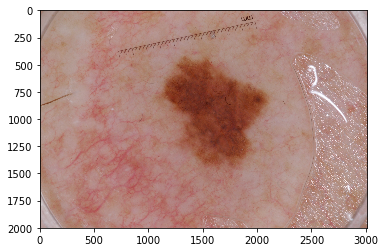

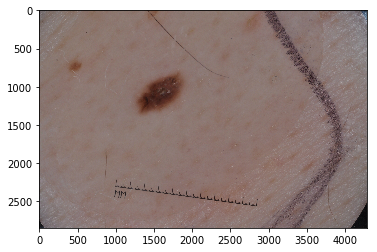

In [14]:
import cv2
for i in range(5):
    img = cv2.imread(melanoma_test_files[i])
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

### Example nevus image

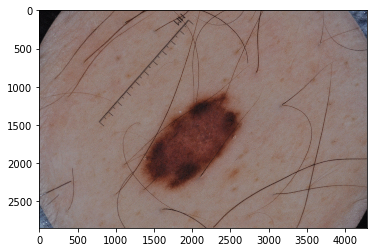

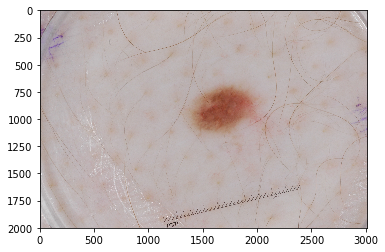

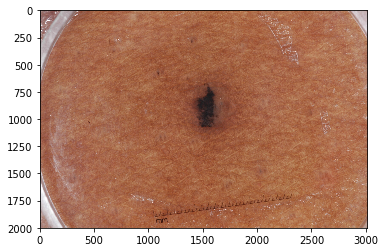

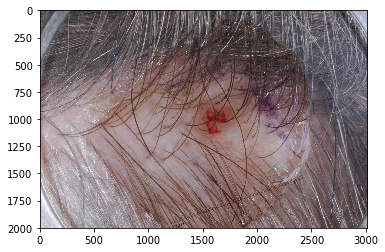

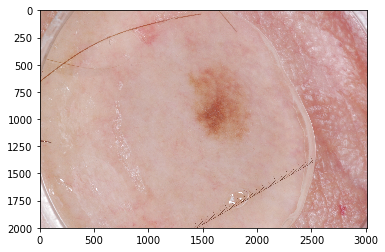

In [15]:
for i in range(5):
    img = cv2.imread(nevus_test_files[i])
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

### Example seborrheic keratosis image

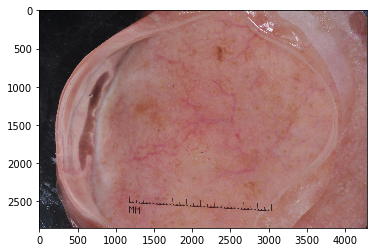

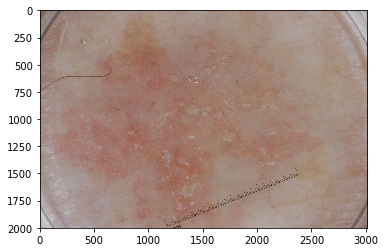

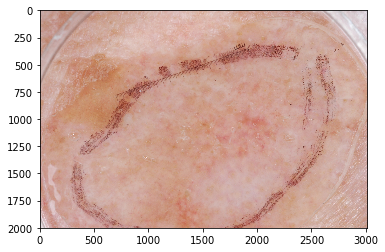

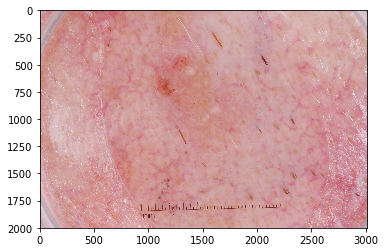

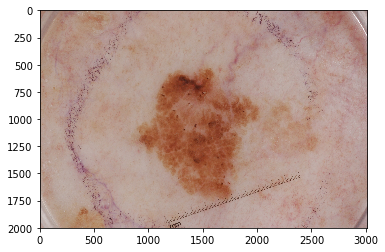

In [16]:
for i in range(5):
    img = cv2.imread(seborrheic_keratosis_test_files[i])
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

In [24]:
import os
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import torch.utils.data
import adabound

use_cuda = torch.cuda.is_available()

In [25]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import time

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
   
    valid_loss_min = np.Inf
    valid_loss_counter = 0
      
    for epoch in range(1, n_epochs+1):
        start = time.time()

            # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            if batch_idx % 500 == 0:
                print(epoch, ':', batch_idx, 'train_loss:', train_loss)

        end = time.time()
        print('Elapsed Epoch Training Time:', end - start)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, 
                                                                                   train_loss,
                                                                                   valid_loss))
                      
        # save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            valid_loss_counter = 0
        else:
            valid_loss_counter += 1
            print('Number of epochs validation loss failed to improve:', valid_loss_counter)
            
        if valid_loss_counter >= 10:
            return model
     
    # return trained model
    return model


In [26]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

In [27]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is torchvision.datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is torchvision.datasets.ImageFolder:
            return dataset.imgs[idx][1]
        else:
            raise NotImplementedError
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

# A few of most accurate recent neural network architectures will be trained and compared to Classify Skin Lesions

# Squeeze and Excitation Network Family Architectures

In [28]:
# model architecture 
from __future__ import print_function, division, absolute_import
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils import model_zoo


__all__ = ['SENet', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152',
           'se_resnext50_32x4d', 'se_resnext101_32x4d']

pretrained_settings = {
    'senet154': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet50': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet101': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet101-7e38fcc6.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet152': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet152-d17c99b7.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def senet154(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEBottleneck, [3, 8, 36, 3], groups=64, reduction=16,
                  dropout_p=0.2, num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['senet154'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet50(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 6, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet50'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet101(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 23, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet101'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet152(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 8, 36, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet152'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

# SE-ResNeXt-50

In [29]:
## SE-ResNeXt-50 uses 224x224 pretraining images

batch_size_SEResNext50 = 4

train_dir = r"D:\Python\Dermatology AI\data\train"
valid_dir = r"D:\Python\Dermatology AI\data\valid"
test_dir = r"D:\Python\Dermatology AI\data\test"

transform_SEResNext50 = transforms.Compose([transforms.Resize((224,224)),
                                             transforms.ToTensor(), 
                                             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_set_SEResNext50 = datasets.ImageFolder(train_dir, transform=transform_SEResNext50)
train_loader_SEResNext50 = torch.utils.data.DataLoader(train_set_SEResNext50,
                                                        batch_size=batch_size_SEResNext50,
                                                        sampler=ImbalancedDatasetSampler(train_set_SEResNext50),
                                                        pin_memory=True)

valid_set_SEResNext50 = datasets.ImageFolder(valid_dir, transform=transform_SEResNext50)
valid_loader_SEResNext50 = torch.utils.data.DataLoader(valid_set_SEResNext50,
                                                        batch_size=batch_size_SEResNext50,
                                                        sampler=ImbalancedDatasetSampler(valid_set_SEResNext50),
                                                        pin_memory=True)

test_set_SEResNext50 = datasets.ImageFolder(test_dir, transform=transform_SEResNext50)
test_loader_SEResNext50 = torch.utils.data.DataLoader(test_set_SEResNext50,
                                                       batch_size=batch_size_SEResNext50,
                                                       sampler=ImbalancedDatasetSampler(test_set_SEResNext50),
                                                       pin_memory=True)

loaders_SEResNext50 = {'train':train_loader_SEResNext50, 
                        'valid': valid_loader_SEResNext50, 
                        'test':test_loader_SEResNext50}

In [30]:
model_SEResNext50 = se_resnext50_32x4d(pretrained='imagenet')

if use_cuda:
    model_SEResNext50 = model_SEResNext50.cuda()

In [9]:
model_SEResNext50

SENet(
  (layer0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (se_module): SEModule(
        (avg_po

In [31]:
n_inputs_SEResNext50 = model_SEResNext50.last_linear.in_features

output_classes_SEResNext50 = 3

# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs_SEResNext50, output_classes_SEResNext50)

model_SEResNext50.last_linear = last_layer

if use_cuda:
    model_SEResNext50.cuda()

# check to see that your last layer produces the expected number of outputs
print(model_SEResNext50.last_linear.out_features)

3


In [32]:
criterion_SEResNext50 = nn.CrossEntropyLoss()
optimizer_SEResNext50 = adabound.AdaBound(model_SEResNext50.parameters())

### Train

In [ ]:
model_SEResNext50 =  train(100, 
                           loaders_SEResNext50, 
                           model_SEResNext50, 
                           optimizer_SEResNext50, 
                           criterion_SEResNext50, 
                           use_cuda, 
                           'model_SEResNext50.pt')

torch.save(model_SEResNext50.state_dict(), 'model_SEResNext50_last_epoch.pt')

### Test

In [14]:
model_SEResNext50.load_state_dict(torch.load('model_SEResNext50_last_epoch.pt'))

test(loaders_SEResNext50, model_SEResNext50, criterion_SEResNext50, use_cuda)

Test Loss: 2.347544


Test Accuracy: 56% (340/600)


In [15]:
# Best perfroming epoch on validation set
model_SEResNext50.load_state_dict(torch.load('model_SEResNext50.pt'))

test(loaders_SEResNext50, model_SEResNext50, criterion_SEResNext50, use_cuda)

Test Loss: 1.315394


Test Accuracy: 54% (324/600)


# SE-ResNeXt-101

In [8]:
## SE-ResNeXt-101 uses 224x224 pretraining images

batch_size_SEResNext101 = 2

train_dir = r"D:\Python\Dermatology AI\data\train"
valid_dir = r"D:\Python\Dermatology AI\data\valid"
test_dir = r"D:\Python\Dermatology AI\data\test"

transform_SEResNext101 = transforms.Compose([transforms.Resize((224,224)),
                                             transforms.ToTensor(), 
                                             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_set_SEResNext101 = datasets.ImageFolder(train_dir, transform=transform_SEResNext101)
train_loader_SEResNext101 = torch.utils.data.DataLoader(train_set_SEResNext101,
                                                        batch_size=batch_size_SEResNext101,
                                                        sampler=ImbalancedDatasetSampler(train_set_SEResNext101),
                                                        pin_memory=True)

valid_set_SEResNext101 = datasets.ImageFolder(valid_dir, transform=transform_SEResNext101)
valid_loader_SEResNext101 = torch.utils.data.DataLoader(valid_set_SEResNext101,
                                                        batch_size=batch_size_SEResNext101,
                                                        sampler=ImbalancedDatasetSampler(valid_set_SEResNext101),
                                                        pin_memory=True)

test_set_SEResNext101 = datasets.ImageFolder(test_dir, transform=transform_SEResNext101)
test_loader_SEResNext101 = torch.utils.data.DataLoader(test_set_SEResNext101,
                                                       batch_size=batch_size_SEResNext101,
                                                       sampler=ImbalancedDatasetSampler(test_set_SEResNext101),
                                                       pin_memory=True)

loaders_SEResNext101 = {'train':train_loader_SEResNext101, 
                        'valid': valid_loader_SEResNext101, 
                        'test':test_loader_SEResNext101}

In [9]:
model_SEResNext101 = se_resnext101_32x4d(pretrained='imagenet')

if use_cuda:
    model_SEResNext101 = model_SEResNext101.cuda()

In [10]:
model_SEResNext101

SENet(
  (layer0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (se_module): SEModule(
        (avg_po

In [10]:
n_inputs_SEResNext101 = model_SEResNext101.last_linear.in_features

output_classes_SEResNext101 = 3

# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs_SEResNext101, output_classes_SEResNext101)

model_SEResNext101.last_linear = last_layer

if use_cuda:
    model_SEResNext101.cuda()

# check to see that your last layer produces the expected number of outputs
print(model_SEResNext101.last_linear.out_features)

3


In [11]:
criterion_SEResNext101 = nn.CrossEntropyLoss()
optimizer_SEResNext101 = adabound.AdaBound(model_SEResNext101.parameters())

### Train

In [12]:
model_SEResNext101 =  train(100, 
                            loaders_SEResNext101, 
                            model_SEResNext101, 
                            optimizer_SEResNext101, 
                            criterion_SEResNext101, 
                            use_cuda, 
                            'model_SEResNext101.pt')

torch.save(model_SEResNext101.state_dict(), 'model_SEResNext101_last_epoch.pt')

1 : 0 train_loss: tensor(0.9496, device='cuda:0')
1 : 500 train_loss: tensor(1.1058, device='cuda:0')
Elapsed Epoch Training Time: 730.9500248432159
Epoch: 1 	Training Loss: 1.092248 	Validation Loss: 17.109993
Validation loss decreased (inf --> 17.109993).  Saving model ...
2 : 0 train_loss: tensor(0.8155, device='cuda:0')
2 : 500 train_loss: tensor(1.0672, device='cuda:0')
Elapsed Epoch Training Time: 745.4196240901947
Epoch: 2 	Training Loss: 1.048684 	Validation Loss: 4.316483
Validation loss decreased (17.109993 --> 4.316483).  Saving model ...
3 : 0 train_loss: tensor(1.6561, device='cuda:0')
3 : 500 train_loss: tensor(1.0104, device='cuda:0')
Elapsed Epoch Training Time: 715.1690146923065
Epoch: 3 	Training Loss: 1.007344 	Validation Loss: 1.113274
Validation loss decreased (4.316483 --> 1.113274).  Saving model ...
4 : 0 train_loss: tensor(1.7281, device='cuda:0')
4 : 500 train_loss: tensor(0.9368, device='cuda:0')
Elapsed Epoch Training Time: 712.6333239078522
Epoch: 4 	Traini

### Test

In [13]:
model_SEResNext101.load_state_dict(torch.load('model_SEResNext101_last_epoch.pt'))

test(loaders_SEResNext101, model_SEResNext101, criterion_SEResNext101, use_cuda)

Test Loss: 2.710618


Test Accuracy: 50% (301/600)


In [14]:
# Best perfroming epoch on validation set
model_SEResNext101.load_state_dict(torch.load('model_SEResNext101.pt'))

test(loaders_SEResNext101, model_SEResNext101, criterion_SEResNext101, use_cuda)

Test Loss: 0.988533


Test Accuracy: 52% (312/600)


# Predicting Skin Lesions with the Models

In [18]:
# list of class names by index

#class_names = [item.replace("_", " ") for item in train_set_SEResNext50.classes]
class_names = [item.replace("_", " ") for item in train_set_SEResNext101.classes]

def predict_skin_lesion(img_path, model):
    img = Image.open(img_path)
    #img_tensor = transform_SEResNext50(img)
    img_tensor = transform_SEResNext101(img)
    img_tensor = img_tensor.unsqueeze_(0)
    img_tensor = img_tensor.cuda()
    model.eval()
    output = model(img_tensor)
    pred = output.data.max(1, keepdim=True)[1]
        
    return class_names[pred]

In [18]:
model_SEResNext50.load_state_dict(torch.load('model_SEResNext50.pt'))

In [12]:
model_SEResNext101.load_state_dict(torch.load('model_SEResNext101.pt'))

In [19]:
def test_prediction(img_files, correct_lesion_name, model):
    counter = 0
    for img in img_files:
        prediction = predict_skin_lesion(img, model)
        #print('Predicted skin lesion is:', prediction)
        if prediction == correct_lesion_name:
            counter +=1
    print('Predictions correct:', 100 * (counter/len(img_files)), '%')            

## SE-ResNeXt-50 Tests

In [20]:
test_prediction(melanoma_test_files, 'melanoma', model_SEResNext50)

Predictions correct: 43.58974358974359 %


In [21]:
test_prediction(nevus_test_files, 'nevus', model_SEResNext50)

Predictions correct: 64.63104325699746 %


In [22]:
test_prediction(seborrheic_keratosis_test_files, 'seborrheic keratosis', model_SEResNext50)

Predictions correct: 56.666666666666664 %


## SE-ResNeXt-101 Tests

In [20]:
test_prediction(melanoma_test_files, 'melanoma', model_SEResNext101)

Predictions correct: 28.205128205128204 %


In [21]:
test_prediction(nevus_test_files, 'nevus', model_SEResNext101)

Predictions correct: 54.70737913486005 %


In [22]:
test_prediction(seborrheic_keratosis_test_files, 'seborrheic keratosis', model_SEResNext101)

Predictions correct: 75.55555555555556 %


# Smaller SE-ResNext-50 outperformed 101 layer vesion. Possibly due to smaller model generalizing better, and being less prone to overfitting for this task.